In [4]:
%matplotlib notebook
from brian2 import *
from matplotlib.pyplot import *
import numpy as np
import random as rp
import time
import copy
from data_generator import *
from numpy import loadtxt

import cv2
from matplotlib import pyplot as plt
print(cv2.__version__);
print(np.__version__);

# packages needed for image difference
from skimage.measure import compare_ssim
import argparse
import imutils

from IPython.display import clear_output
import os

import PIL.Image

4.1.0
1.17.4


In [5]:
# Loads in the network from file created after training

data_path = './data1000/'
StE_w = loadtxt(data_path+'StEw.csv', delimiter=',') 
StE_delay = loadtxt(data_path+'StEdelay.csv', delimiter=',')
EtI_w = loadtxt(data_path+'EtIw.csv', delimiter=',')
mapped = loadtxt(data_path+'Map.csv', delimiter=',')


#Decides how many of the left/right neurons we use
left_percent = 0.1
right_percent = 0.9

left_neurons = []
right_neurons = []
for j in range(len(mapped)):
    if mapped[j] < int(len(mapped)*left_percent):
        left_neurons.append(j)
    elif mapped[j] > int(len(mapped)*right_percent):
        right_neurons.append(j)
        
start_scope()
eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
th : 1
'''

taupre = taupost = 100*ms
wmax = 2
wmin = 0.001
Apre = 0
Apost = -Apre*taupre/taupost*1.05

inner_size = len(EtI_w)
S = NeuronGroup(256, eqs, threshold='v>1', reset='v = 0', method='exact')
E = NeuronGroup(inner_size, eqs, threshold='v>1.5', reset='v = 0', method='exact')
I = NeuronGroup(inner_size, eqs, threshold='v>0.5', reset='v = 0', method='exact')

# When validating we don't need STDP (improves performance)
StE= Synapses(S, E, 'w : 1', on_pre='v_post += w')
StE.connect(p=1)

EtI= Synapses(E, I, 'w : 1', on_pre='v_post += w')
EtI.connect(condition='i==j')


ItE= Synapses(I, E,  'w : 1', on_pre='v_post = 0')
ItE.connect(condition='i!=j')

taupre = taupost = 100*ms
wmax = 2
wmin = 0.001
Apre = 0
Apost = -Apre*taupre/taupost*1.5

S.tau=60*ms
S.I=0
E.tau=100*ms
E.I=0

I.tau=50*ms

StE.w = StE_w
for j in range(len(StE_delay)): 
    StE.delay[j] = StE_delay[j]*second
EtI.w = EtI_w

# Add the output layer
OUT = NeuronGroup(2, eqs, threshold='v>th', reset='v = 0', method='exact')
OUT.th = '1'
OUT.tau=10*ms

EtOUT= Synapses(E, OUT, 'w : 1', on_pre='v_post += w')

# Connect left_neurons to one output and right_neurons to the other
EtOUT.connect(i=left_neurons, j=0)
EtOUT.connect(i=right_neurons, j=1)
EtOUT.w = 1

M = StateMonitor(S, 'v', record=True)
spikemonE = SpikeMonitor(E)
spikemonI = SpikeMonitor(I)
spikemonS = SpikeMonitor(S)
spikemonOUT = SpikeMonitor(OUT)

net = Network(S, E, I, StE, EtI, ItE, OUT, EtOUT, spikemonE, spikemonI, spikemonS, spikemonOUT)

print("done")

done


In [10]:
def run_data(data, time_step=33*ms):
    
    for j in range(len(data)):
        clear_output();
        print("Row {}/{}".format(j+1, len(data)))
        S.I=[f[0]*6/255 for f in data[j]]
        run(time_step)
    
    imgplot = plt.imshow(data/255) 
    plt.show()
        
def run_network(data):
    
    start = time.time()
    run_data(data)
    print(time.time() - start,"s")

    figure(20)
    plot(spikemonOUT.t/ms, spikemonOUT.i, '.k')

In [11]:
def cameraloop(cap):

    first_flag = 0;
    second_flag = 0;

    recorded = np.zeros((1,256))
    
    while(True):
        
        # Capture frame-by-frame
        ret, frame = cap.read()

        if first_flag == 1:
            last_gray = copy.copy(gray)
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            dst1 = gray
            dst2 = last_gray

            if (second_flag == 1):
                last_thresh = thresh

            (score, diff) = compare_ssim(dst1, dst2, full=True)
            diff = (diff * 255).astype("uint8")
            
            # lower sens reduces noise in the picture
            sens = 40
            diff[diff > sens] = 255
            diff[diff <= sens] = 0

            x = diff.shape[0]
            y = diff.shape[1]

            a = int(round(x/2 - 1, 0))
            b = int(round(x/2,0))
            c = int(round(y/2))
            d = int(round(256/2))

            thresh = cv2.bitwise_not(diff)

            diff_row = thresh[a:b, c-d:c+d]
            recorded = np.vstack((recorded, diff_row))

        if first_flag == 1:
            cv2.imshow('thresh', thresh)
        else:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        if (second_flag == 1):
            #cv2.imshow('row', diff_row)
            cv2.imshow('recorded', recorded)

        if cv2.waitKey(20) & 0xFF == ord('q'):
            break
        if cv2.waitKey(20) & 0xFF == ord('r'):            
            
            # Formats data and inputs to the network
            recorded_rgb = cv2.cvtColor(recorded.astype('float32'),cv2.COLOR_GRAY2RGB)
            run_network(recorded_rgb)
                        
        if cv2.waitKey(20) & 0xFF == ord('x'):
            recorded = np.zeros((1,256))
            
        if (first_flag == 1):
            second_flag = 1;

        first_flag = 1

# X to reset the image
# R to record the image and run the network on the image
# Q to exit the camera

Row 43/43


<IPython.core.display.Javascript object>


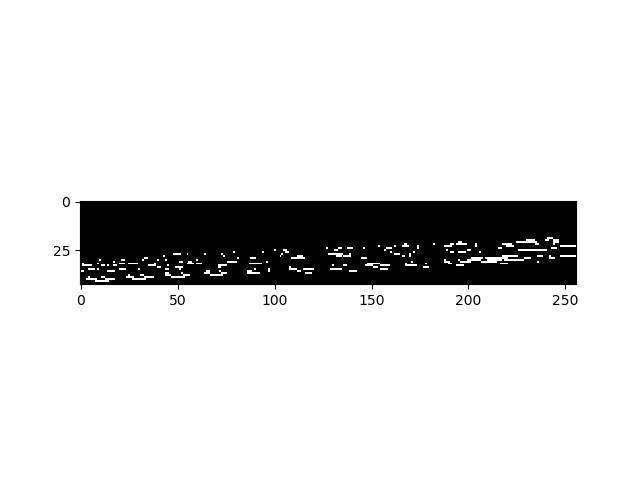

9.646387815475464 s


<IPython.core.display.Javascript object>


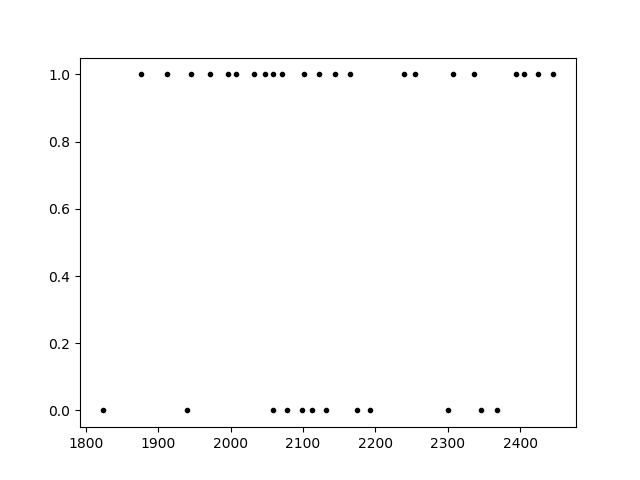

LEFT! 
22  left spikes and  12  right spikes


In [12]:
Apre = 0
Apost = 0
del spikemonOUT
spikemonOUT = SpikeMonitor(OUT)

# Getting the keys to work might be a problem but hopefully you can solve it
# Pressing one of these keys in the camera window will do the following:
# Q = exits the program
# (hold) R = runs the network on the image
# (hold) X = refreshes the recorded data

cap = cv2.VideoCapture(0)

cameraloop(cap)

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

l_spike = 0
r_spike = 0
for spike in spikemonOUT.i:
    if spike == 0:
        r_spike += 1
    else:
        l_spike += 1
#print("LEFT: ", l_spike, " RIGHT: ", r_spike)

tot_spike = l_spike+r_spike
certainty = round(abs(l_spike - r_spike)*100/tot_spike, 0)
if l_spike > r_spike:
    print("LEFT! ") #Test Score: ", certainty, "/100")
else:
    print("RIGHT! ")#Test Score: ", certainty, "/100")
          
print(l_spike, " left spikes and ", r_spike, " right spikes")